## Data Science Programming Final Project
### Title Generation using LSTM
Authors:

Bindu Krishnouth - U54299242

Saranya Chintalapati - U76825685

Keerthi Bai reddy - U918889334

Suraj Varma Dantuluri - U00256679
 
Mukesh Sai Bodapati - U29479766

### Import Packages

In [22]:
import pandas as pd
import string
import numpy as np
import json

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import tensorflow as tf
tf.random.set_seed(20)
from numpy.random import seed
seed(100)


### Load the Data

In [23]:
#load all the datasets 
df1 = pd.read_csv('USvideos.csv')
df2 = pd.read_csv('CAvideos.csv')
df3 = pd.read_csv('GBvideos.csv')

#load the datasets containing the category names
data1 = json.load(open('US_category_id.json'))
data2 = json.load(open('CA_category_id.json'))
data3 = json.load(open('GB_category_id.json'))

### Data Pre-processing

In [24]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

#create a new category column by mapping the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))

#join the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

#drop rows based on duplicate videos
df = df.drop_duplicates('video_id')

#collect only titles of entertainment videos
#feel free to use any category of video that you want
comedy = df[df['category_title'] == 'Comedy']['title']
comedy = comedy.tolist()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

#remove punctuations and convert text to lowercase
def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

corpus = [clean_text(e) for e in comedy]

In [25]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_title
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [26]:
df['category_title'].unique()

array(['People & Blogs', 'Entertainment', 'Comedy',
       'Science & Technology', 'Film & Animation', 'News & Politics',
       'Sports', 'Music', 'Pets & Animals', 'Education', 'Howto & Style',
       'Autos & Vehicles', 'Travel & Events', 'Gaming',
       'Nonprofits & Activism', 'Shows', nan, 'Movies'], dtype=object)

In [27]:
df['category_title'].value_counts()

category_title
Entertainment            9730
News & Politics          3415
People & Blogs           3071
Music                    2479
Sports                   2422
Comedy                   2305
Howto & Style            1780
Film & Animation         1431
Gaming                    966
Science & Technology      900
Education                 763
Pets & Animals            325
Autos & Vehicles          310
Travel & Events           247
Shows                     106
Nonprofits & Activism      14
Movies                      1
Name: count, dtype: int64

In [28]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(corpus):
    # Get tokens
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    # Convert to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences, total_words
 
inp_sequences, total_words = get_sequence_of_tokens(corpus)

In [29]:
from tensorflow.keras.utils import to_categorical

def generate_padded_sequences(input_sequences, total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

### Model Architecture

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Generate padded sequences
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences, total_words)

def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add Hidden Layer 1 — LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))

    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model


### Train Model

In [31]:
model = create_model(max_sequence_len, total_words)
history = model.fit(predictors, label, epochs=20, verbose=1)  # Set verbose to 1 for progress updates

Epoch 1/20
432/432 [==============================] - 11s 20ms/step - loss: 7.8731
Epoch 2/20
432/432 [==============================] - 9s 20ms/step - loss: 7.3716
Epoch 3/20
432/432 [==============================] - 8s 20ms/step - loss: 7.1656
Epoch 4/20
432/432 [==============================] - 8s 19ms/step - loss: 6.9356
Epoch 5/20
432/432 [==============================] - 8s 19ms/step - loss: 6.6763
Epoch 6/20
432/432 [==============================] - 8s 18ms/step - loss: 6.4284
Epoch 7/20
432/432 [==============================] - 8s 18ms/step - loss: 6.1937
Epoch 8/20
432/432 [==============================] - 8s 18ms/step - loss: 5.9710
Epoch 9/20
432/432 [==============================] - 8s 18ms/step - loss: 5.7539
Epoch 10/20
432/432 [==============================] - 8s 18ms/step - loss: 5.5509
Epoch 11/20
432/432 [==============================] - 8s 18ms/step - loss: 5.3530
Epoch 12/20
432/432 [==============================] - 10s 23ms/step - loss: 5.1658
Epoch 13/20

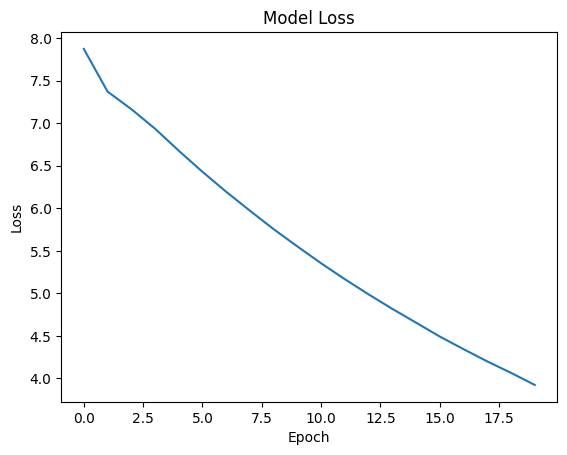

In [32]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Text Generation

In [33]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)

        # Find the word with the highest probability
        predicted = np.argmax(predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text.title()


In [34]:
print(generate_text("Stand-up", 5, model, max_sequence_len))

Stand-Up With The Week Tonight With


## Model 2
1. Performed L2 Regularization
2. Increased the LSTM units to 256
3. Increased the dropout rate to 0.2

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2

# Generate padded sequences
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences, total_words)

def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add Hidden Layer 1 — LSTM Layer
    model.add(LSTM(256))
    model.add(Dropout(0.2))

    # Add Output Layer
    model.add(Dense(total_words, activation='softmax', kernel_regularizer=l2(0.01)))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(max_sequence_len, total_words)
history = model.fit(predictors, label, epochs=20, verbose=1)  # Set verbose to 1 for progress updates


Epoch 1/20
432/432 [==============================] - 20s 42ms/step - loss: 8.1835
Epoch 2/20
432/432 [==============================] - 18s 41ms/step - loss: 7.7973
Epoch 3/20
432/432 [==============================] - 18s 41ms/step - loss: 7.6601
Epoch 4/20
432/432 [==============================] - 18s 42ms/step - loss: 7.5805
Epoch 5/20
432/432 [==============================] - 288s 669ms/step - loss: 7.5115
Epoch 6/20
432/432 [==============================] - 18s 41ms/step - loss: 7.4696
Epoch 7/20
432/432 [==============================] - 18s 41ms/step - loss: 7.4348
Epoch 8/20
432/432 [==============================] - 18s 42ms/step - loss: 7.4072
Epoch 9/20
432/432 [==============================] - 18s 41ms/step - loss: 7.3816
Epoch 10/20
432/432 [==============================] - 18s 41ms/step - loss: 7.3630
Epoch 11/20
432/432 [==============================] - 18s 42ms/step - loss: 7.3427
Epoch 12/20
432/432 [==============================] - 34s 78ms/step - loss: 7.3288

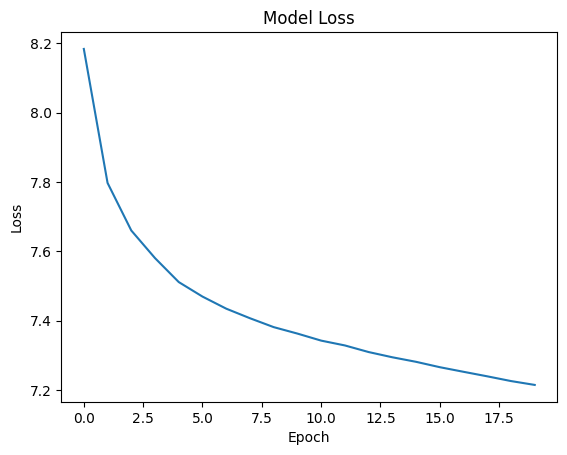

In [36]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [37]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)

        # Find the word with the highest probability
        predicted = np.argmax(predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text.title()


In [38]:
print(generate_text("Stand-up", 3, model, max_sequence_len))

Stand-Up With Daily Show


### Model 3
1. Added an LSTM Layer with 50 units
2. Performed the model with "rmsprop" optimizer

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Generate padded sequences
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences, total_words)

def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    #Increase embedding dimension
    model.add(Embedding(total_words, 50, input_length=input_len))  

    model.add(LSTM(100, return_sequences=True))  # Add another LSTM layer
    model.add(LSTM(50))  # Add another LSTM layer

    model.add(Dropout(0.2))


    # Add Output Layer
    model.add(Dense(total_words, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop') 

    return model

model = create_model(max_sequence_len, total_words)
history = model.fit(predictors, label, epochs=20, verbose=1)  # Set verbose to 1 for progress updates

Epoch 1/20
432/432 [==============================] - 53s 102ms/step - loss: 7.7893
Epoch 2/20
432/432 [==============================] - 297s 689ms/step - loss: 7.5974
Epoch 3/20
432/432 [==============================] - 44s 101ms/step - loss: 7.5653
Epoch 4/20
432/432 [==============================] - 44s 102ms/step - loss: 7.4970
Epoch 5/20
432/432 [==============================] - 45s 103ms/step - loss: 7.4175
Epoch 6/20
432/432 [==============================] - 45s 104ms/step - loss: 7.3425
Epoch 7/20
432/432 [==============================] - 44s 103ms/step - loss: 7.2775
Epoch 8/20
432/432 [==============================] - 43s 99ms/step - loss: 7.2176
Epoch 9/20
432/432 [==============================] - 44s 102ms/step - loss: 7.1737
Epoch 10/20
432/432 [==============================] - 44s 102ms/step - loss: 7.1388
Epoch 11/20
432/432 [==============================] - 38s 88ms/step - loss: 7.0968
Epoch 12/20
432/432 [==============================] - 40s 93ms/step - loss

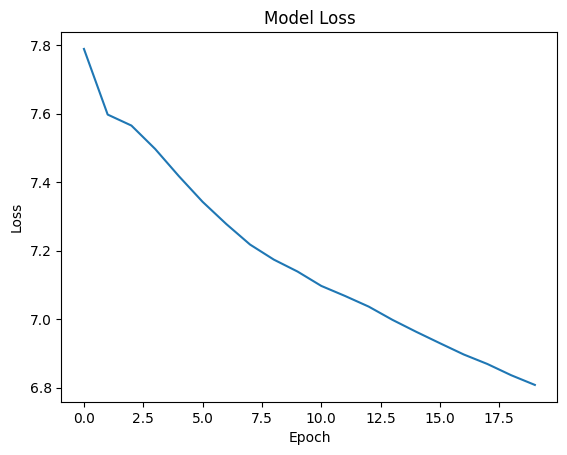

In [40]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [41]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)

        # Find the word with the highest probability
        predicted = np.argmax(predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text.title()


In [42]:
print(generate_text("Stand-up", 4, model, max_sequence_len))

Stand-Up With The Lip Best
